In [8]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('white')

from covid.utils import files_paths_labels

In [3]:
PATH_TRAIN = 'Data/CT-COV19/Train'
PATH_VAL = 'Data/CT-COV19/Val'

In [4]:
files_paths_train, files_labels_train = files_paths_labels(PATH_TRAIN, 'Train')
files_paths_val, files_labels_val = files_paths_labels(PATH_VAL, 'Val')

Train 4404 4404
Val 1341 1341


## Patient's contour

In [5]:
def find_body_contour(img, show_steps=False, correct_mask=False, crop=False):
    img = np.squeeze(img)
    img = img.astype(np.uint8)
    
    retval, img_thresh = cv2.threshold(img, thresh=150, maxval=255, type=cv2.THRESH_BINARY)
    
    top = int(0.05 * img.shape[0])
    bottom = top
    left = int(0.05 * img.shape[1])
    right = left
    
    img_border = cv2.copyMakeBorder(img_thresh, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 0)
   
    kernel = np.ones((3, 3), np.uint8)
    img_border_a = cv2.erode(img_border, kernel, 10)
    
    img_border_b = cv2.bitwise_not(img_border_a)
    img_edges = cv2.Canny(img_border_b, 240, 255)
    
    kernel = np.ones((3, 3), np.uint8)
    img_dilated = cv2.dilate(img_edges, kernel, 2)
    
    contours, hierarchy = cv2.findContours(img_dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if_contour = 1
    max_contour = contours[0]
    max_hull = cv2.convexHull(contours[0])
    max_hull_perimeter = cv2.arcLength(max_hull, True)
    
    for contour in contours:
        hull = cv2.convexHull(contour)
        
        if cv2.arcLength(contour, True) > cv2.arcLength(max_contour, True):
            max_contour = contour
            if_contour = 1
        
        elif cv2.arcLength(hull, True) > max_hull_perimeter:
            max_hull_perimeter = cv2.arcLength(hull, True)
            max_hull = hull
            max_contour = contour
            if_contour = 0
        
    max_contour = max_contour - top
    
    img_body_contour = cv2.drawContours(img.copy(), [max_contour], 0, (0, 255, 0), 2)

    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    mask = cv2.fillPoly(mask, [max_contour], (1.0, 1.0, 1.0))
    
    
    if correct_mask:
        non_zero_indices = np.argwhere(mask[0,:])

        if non_zero_indices.size:
            mask[0:5,int(non_zero_indices[0]):int(non_zero_indices[-1])] = 1
            mask_border = cv2.copyMakeBorder(mask, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 0)

            mask_fill = np.zeros((mask_border.shape[0]+2, mask_border.shape[1]+2), dtype=np.uint8)
            cv2.floodFill(mask_border, mask_fill, (0,0), 255)
            mask_fill = cv2.bitwise_not(mask_fill)

            mask = mask_fill[top:mask_fill.shape[0]-bottom-2, left:mask_fill.shape[1]-right-2]
            mask = mask - np.min(mask)
    
    
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    output = img_masked
    
    if crop:
        x, y, w, h = cv2.boundingRect(max_contour)
        x = np.max([x,0])
        y = np.max([y,0])

        y_center = np.argwhere(img_masked[:, int(img_masked.shape[1]//2)])[0][0]
        if y < y_center:
            h = h - (y_center - y)
            y = y_center

        img_body_bbox = cv2.rectangle(img_masked.copy(), (x,y), (x+w-1,y+h-1), (0,255,0), 4)
        img_cropped = img_masked.copy()
        img_cropped = img_cropped[y:y+h, x:x+w]
        output = img_cropped

    
    if show_steps:
        images = [img, img_thresh, img_border, img_border_a, img_border_b, img_edges, img_dilated, img_body_contour, mask, img_masked]
        titles = ['img', 'img_thresh', 'img_border', 'img_border_a', 'img_border_b', 'img_edges', 'img_dilated', 'img_body_contour', 'mask', 'img_masked']

        plt.figure(figsize=(25,17))
        
        for i, img_ in enumerate(images):
            plt.subplot(3,4,i+1)
            plt.imshow(img_)
            plt.title(str(i+1) + ' ' + titles[i])
            plt.axis('off');
            
        if crop:
            plt.subplot(3,4,11)
            plt.imshow(img_body_bbox, cmap='gray')
            plt.title('11 img_body_bbox')
            plt.axis('off')
            plt.subplot(3,4,12)
            plt.imshow(img_cropped, cmap='gray')
            plt.title('12 img_cropped')
            plt.axis('off')

    
    return output

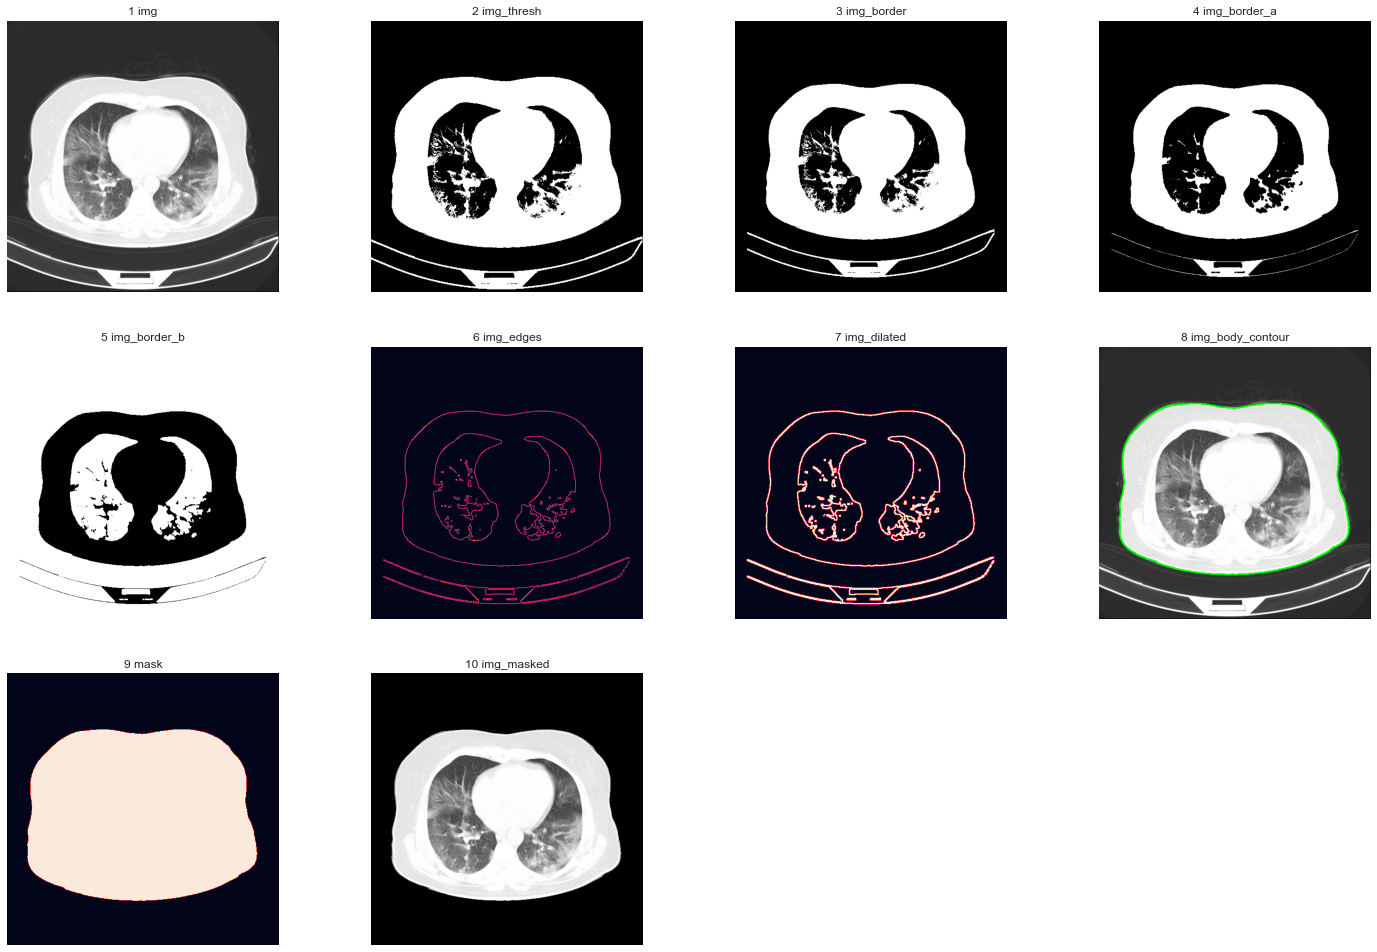

In [9]:
find_body_contour(cv2.imread(files_paths_train[10]), show_steps=True);

### Mask corrections

In some cases mask correction using floodFill is needed.

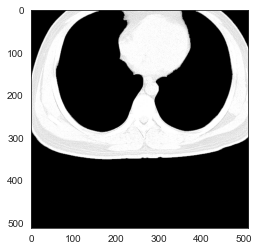

In [10]:
plt.imshow(find_body_contour(cv2.imread(files_paths_val[1231])));

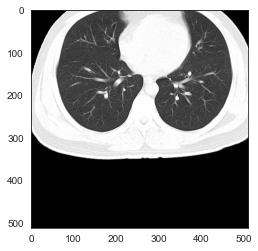

In [11]:
plt.imshow(find_body_contour(cv2.imread(files_paths_val[1231]), correct_mask=True));

## Crop

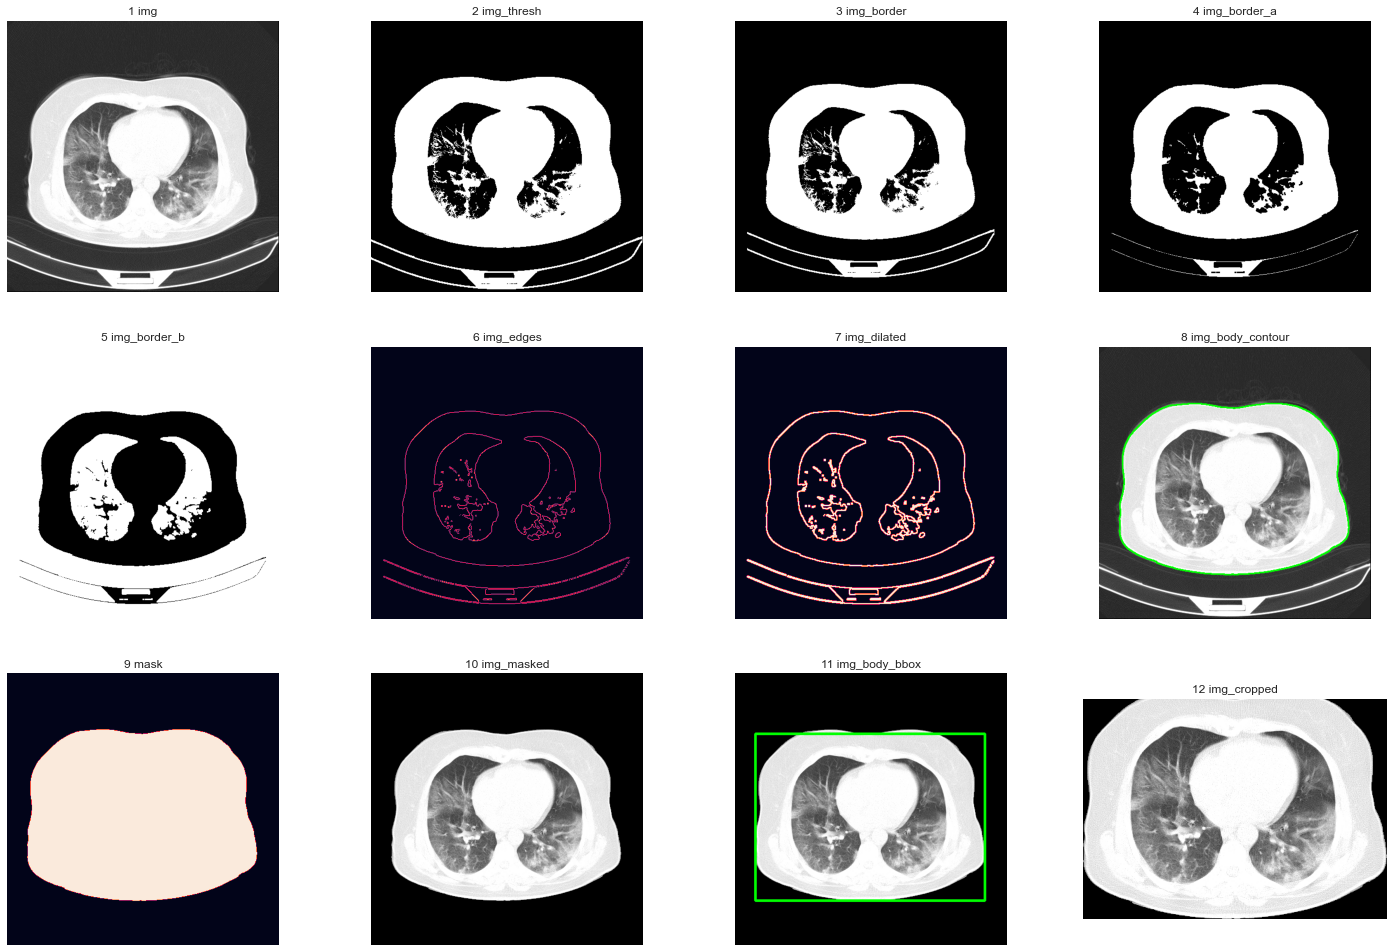

In [12]:
find_body_contour(cv2.imread(files_paths_train[10]), show_steps=True, crop=True);

When patient's arms are visible as on the image below, the bounding box y coordinate is adjusted so that the height of the bounding box is taken as patient's width in the middle of the image. Thus, the arms and the area between them are removed as they are irrelevant to the model predictions.

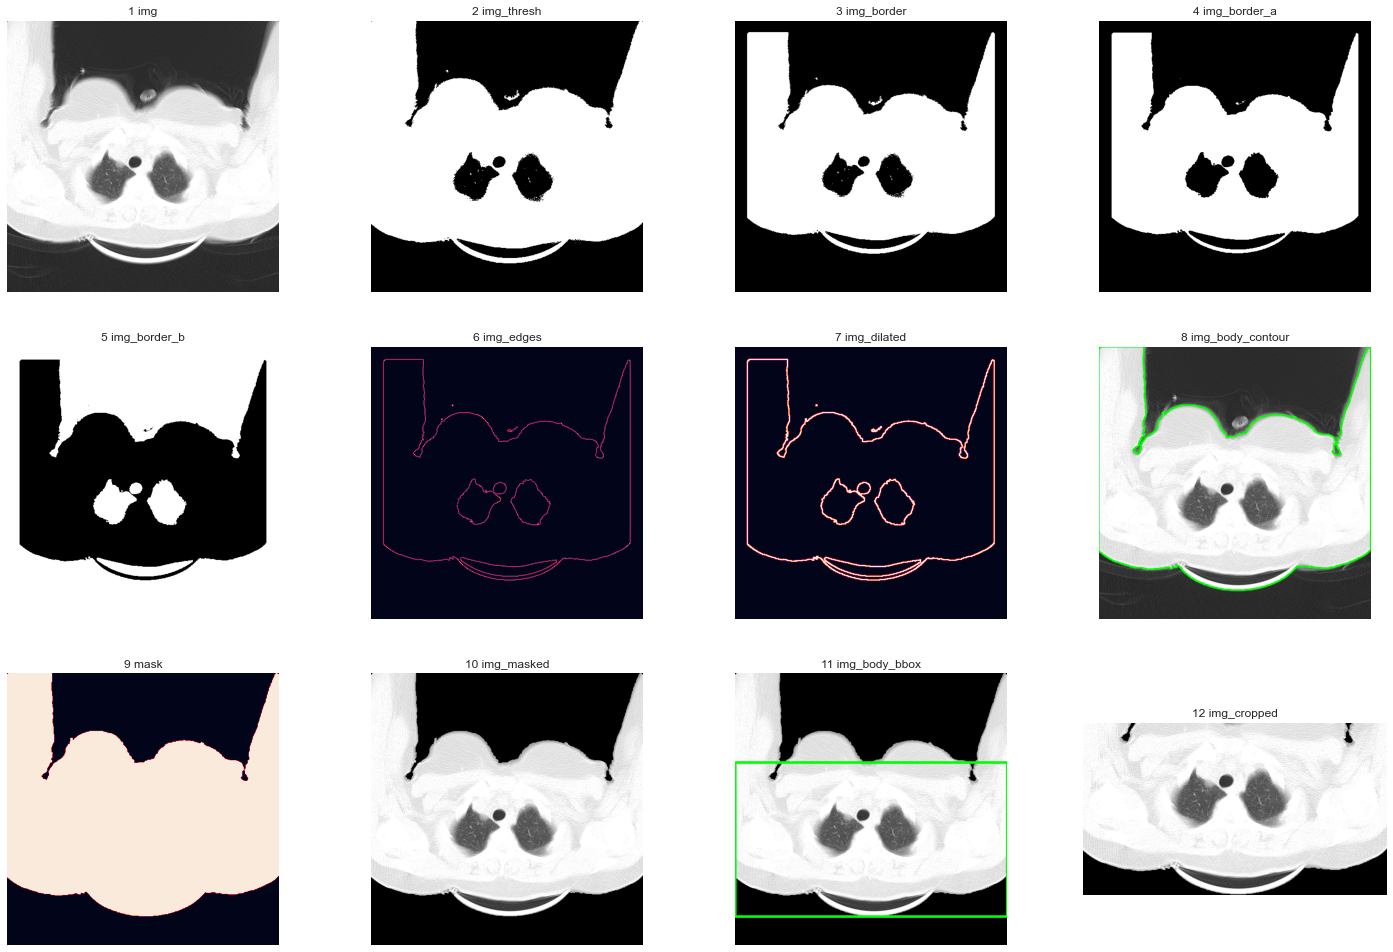

In [13]:
find_body_contour(cv2.imread(files_paths_train[1379]), show_steps=True, crop=True);

## Save to folder

In [30]:
def save_to_folder(img_paths, img_labels, path_to_folder, if_resize=True, size=(512,512), correct_mask=False, crop=False):
    for i, path in enumerate(img_paths):
        print(path)
        img_ = cv2.imread(path)
        
        if if_resize:    
            if img_.shape[0] != size[0] or img_.shape[1] != size[1]:
                img_ = cv2.resize(img_, size)
        
        img_ = find_body_contour(img_, correct_mask=correct_mask, crop=crop)

        if img_labels[i] == 'COV':
            status = cv2.imwrite(path_to_folder + '/COV/' + str(i) + '.png', img_)

        elif img_labels[i] == 'Normal':
            status = cv2.imwrite(path_to_folder + '/Normal/' + str(i) + '.png', img_)

        else:
            status = cv2.imwrite(path_to_folder + '/OtherPneumonia/' + str(i) + '.png', img_)

        if not status:
            print('fail', i)

In [ ]:
save_to_folder(files_paths_train, files_labels_train, 'Data/CT-COV-Contour/Train')

In [ ]:
save_to_folder(files_paths_val, files_labels_val, 'Data/CT-COV-Contour/Val')